outline

- 数据并行是切数据（scattering inputs and gathering outputs），模型并行是切模型（shards）
    - 模型并行：单卡放不下一份模型；
    - 将一份大模型，不同的层切分到不同的卡上
- device_map：Huggingface
- 模型并行 on ToyModel
- 模型并行：on ResNet
- 不需要引入额外的 torch api 支持；

`device_map` 是 Hugging Face Transformers 库中的一个参数，主要用于控制模型在多设备（如多块GPU）环境下的负载分配。当加载大型模型进行推理或训练时，可以通过 `device_map` 将模型的不同层自动或手动分配到不同的计算设备上，以实现资源的高效利用和并行计算。
主要功能与用法：
- 自动分配：  
  设置 `device_map="auto"` 时，Transformers 会结合 Accelerate 库自动将模型各层分配到可用设备上，优先使用 GPU 显存，若显存不足则使用 CPU 内存或磁盘空间。
  
- 多种分配策略：  
  - `"auto"` / `"balanced"`：在所有 GPU 上均匀分配模型层。  
  - `"balanced_low_0"`：除第一个 GPU 外，其他 GPU 均衡分配，第一个 GPU 占用较少资源，适合需要在 GPU 0 上执行生成任务（如 `generate`）的场景。  
  - `"sequential"`：按顺序分配，优先填满 GPU 0，再依次向后分配。
- 手动配置：  
  可自定义 `device_map` 为字典形式，指定模型的每个模块分配到哪个设备（如 `"cuda:0"`、`"cuda:1"` 或 `"cpu"`），适用于精细控制模型部署场景。
- 与量化结合使用：  
  在使用 4 位或 8 位量化（如 BitsAndBytes）时，`device_map="auto"` 可让模型在低显存设备上运行，通过将部分层卸载到 CPU 或磁盘来节省显存。
典型应用场景：
- 单机多卡推理，提升大模型推理速度。
- 显存不足时，通过 CPU 或磁盘扩展内存，实现大模型加载。
- 多任务并行推理，充分利用多设备资源。
简而言之，`device_map` 是实现模型并行、资源优化和高效推理的关键工具，特别适用于大模型在多设备环境下的部署。


In [ ]:
import os#环境代理设置
os.environ["http_proxy"] = "http://127.0.0.1:7890"
os.environ["https_proxy"] = "http://127.0.0.1:7890"

In [4]:
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig
model = LlamaForCausalLM.from_pretrained("NousResearch/Llama-2-7b-chat-hf",
                                         load_in_8bit=True,
                                         device_map="auto")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
for i, para in enumerate(model.named_parameters()):
    print(f"{i},\t {para[0]}, \t {para[1].device} \t {para[1].dtype}")

0,	 model.embed_tokens.weight, 	 cuda:0 	 torch.float16
1,	 model.layers.0.self_attn.q_proj.weight, 	 cuda:0 	 torch.int8
2,	 model.layers.0.self_attn.k_proj.weight, 	 cuda:0 	 torch.int8
3,	 model.layers.0.self_attn.v_proj.weight, 	 cuda:0 	 torch.int8
4,	 model.layers.0.self_attn.o_proj.weight, 	 cuda:0 	 torch.int8
5,	 model.layers.0.mlp.gate_proj.weight, 	 cuda:0 	 torch.int8
6,	 model.layers.0.mlp.up_proj.weight, 	 cuda:0 	 torch.int8
7,	 model.layers.0.mlp.down_proj.weight, 	 cuda:0 	 torch.int8
8,	 model.layers.0.input_layernorm.weight, 	 cuda:0 	 torch.float16
9,	 model.layers.0.post_attention_layernorm.weight, 	 cuda:0 	 torch.float16
10,	 model.layers.1.self_attn.q_proj.weight, 	 cuda:0 	 torch.int8
11,	 model.layers.1.self_attn.k_proj.weight, 	 cuda:0 	 torch.int8
12,	 model.layers.1.self_attn.v_proj.weight, 	 cuda:0 	 torch.int8
13,	 model.layers.1.self_attn.o_proj.weight, 	 cuda:0 	 torch.int8
14,	 model.layers.1.mlp.gate_proj.weight, 	 cuda:0 	 torch.int8
15,	 model.layer

toy example

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        self.net1 = torch.nn.Linear(10000, 10).to('cuda:0')
        self.relu = torch.nn.ReLU()
        self.net2 = torch.nn.Linear(10,5).to('cuda:1')

    def forward(self, x):
        x = self.relu(self.net1(x.to('cuda:0')))
        return self.net2(x.to('cuda:1'))

In [35]:
model = ToyModel()

PyTorch 的全连接层（`Linear` 层）数学形式是：`y = xW^T + b`

其中：
- 输入维度 `in_features = 10000`
- 输出维度 `out_features = 10`

---

### 参数分析

`torch.nn.Linear` 层包含两个参数：
1. **权重（weight）**：形状为 `(out_features, in_features)` → `(10, 10000)`
2. **偏置（bias）**：形状为 `(out_features,)` → `(10,)`

---

### `model.net1.parameters()` 是什么？

`model.net1.parameters()` 是一个 **Python 生成器**，它会依次返回该层的所有可训练参数（即 weight 和 bias）。

### 补充说明

- `parameters()` 返回的是 **可训练参数**，即会被优化器更新的张量。
- 如果你只想看某个参数，比如权重，可以直接访问：
  ```python
  model.net1.weight.shape  # torch.Size([10, 10000])
  model.net1.bias.shape    # torch.Size([10])
  ```

---

### 小结一句话：

> `model.net1.parameters()` 会返回两个张量：一个是形状为 `(10, 10000)` 的权重矩阵，另一个是形状为 `(10,)` 的偏置向量。

In [36]:
print(next(model.net1.parameters()).device)
print(list(model.net2.parameters())[0].device)

cuda:0
cuda:1


In [37]:
model = ToyModel()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

optimizer.zero_grad()
outputs = model(torch.randn(20, 10000))
labels = torch.randn(20, 5).to('cuda:1') 
loss_fn(outputs, labels).backward()
optimizer.step()

split ResNet

model = ResNet(block, layers, **kwargs)

**resnet18**
_resnet(BasicBlock, [2, 2, 2, 2])

**resnet34**
_resnet(BasicBlock, [3, 4, 6, 3])

**resnet50**
_resnet(Bottleneck, [3, 4, 6, 3])

**resnet101**
_resnet(Bottleneck, [3, 4, 23, 3])

**resnet152**
_resnet(Bottleneck, [3, 8, 36, 3])

In [38]:

import torch
from torch import nn
from torchvision.models.resnet import ResNet, Bottleneck

In [39]:
model = ResNet(Bottleneck, [3,4,6,3])

In [40]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [41]:
from torchsummary import summary

In [42]:
summary(model, input_size=(3, 128, 128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

自定义模型并行

In [43]:
import torch
t = torch.rand((2,3,4))
print(t.shape)
t.view(t.size(0),-1).shape

torch.Size([2, 3, 4])


torch.Size([2, 12])

In [80]:
class ModelParallerResNet50(ResNet):
    def __init__(self, num_classes=1000):
        super().__init__(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)
        self.seq1 = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.maxpool,
            self.layer1, 
            self.layer2
        ).to('cuda:0')

        self.seq2 = nn.Sequential(
            self.layer3,
            self.layer4,
            self.avgpool,
        ).to('cuda:5')

        self.fc.to('cuda:7')

    def forward(self, x):
        x = self.seq2(self.seq1(x.to('cuda:0')).to('cuda:5'))
        return self.fc(x.view(x.size(0),-1).to('cuda:7'))

In [81]:
def model_size(model):
    return sum([para.numel() for para in model.parameters()])

In [82]:
model_size(ResNet(Bottleneck, [3, 4, 6, 3]))

25557032

train pipeline

In [83]:
num_classes = 10

In [84]:
one_hot_indices = torch.LongTensor(5) \
                           .random_(0, num_classes) \
                           .view(5, 1)
one_hot_indices

tensor([[0],
        [8],
        [8],
        [2],
        [2]])

In [85]:
labels = torch.zeros(5, num_classes).scatter_(1, one_hot_indices, 1)
labels

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [86]:
a = torch.tensor([1]*10).unsqueeze(0)
print(a)
torch.zeros(5, num_classes).scatter_(0, a, 1)

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [87]:
num_classes = 1000
num_batches = 3
batch_size = 120
image_w = 128
image_h = 128

def train(model):
    model.train(True)
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    one_hot_indices = torch.LongTensor(batch_size) \
                           .random_(0, num_classes) \
                           .view(batch_size, 1)
    
    for _ in range(num_batches):
        inputs = torch.randn(batch_size, 3, image_w, image_h)
        labels = torch.zeros(batch_size, num_classes).scatter_(1, one_hot_indices, 1)

        optimizer.zero_grad()
        outputs = model(inputs.to('cuda:0'))
        print("outputs.device:",outputs.device)
        labels = labels.to(outputs.device)
        loss_fn(outputs, labels).backward()
        optimizer.step()

In [88]:
import matplotlib.pyplot as plt
# plt.switch_backend('Agg')
import numpy as np
import timeit

num_repeat = 10

stmt = "train(model)"

# 模型并行
setup = "model = ModelParallerResNet50()"
mp_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
mp_mean, mp_std = np.mean(mp_run_times), np.std(mp_run_times)

# 单卡
setup = "import torchvision.models as models;" + \
        "model = models.resnet50(num_classes=num_classes).to('cuda:0')"
rn_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
rn_mean, rn_std = np.mean(rn_run_times), np.std(rn_run_times)


outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:7
outputs.device: cuda:0
outputs.device: cuda:0
outputs.device: cuda:0
outputs.device: cuda:0
outputs.device: cuda:0
outputs.device: cuda:0
outputs.device: cuda:0
outputs.device: cuda:0
outputs.device: cuda:0
outputs.device: cuda:0
outputs.device: cuda:0
outputs.device: cuda:0
outputs.device: cuda:0
outputs.dev

In [89]:
def plot(means, stds, labels, fig_name):
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(means)), means, yerr=stds,
           align='center', alpha=0.5, ecolor='red', capsize=10, width=0.6)
    ax.set_ylabel('ResNet50 Execution Time (Second)')
    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(labels)
    ax.yaxis.grid(True)
    plt.tight_layout()

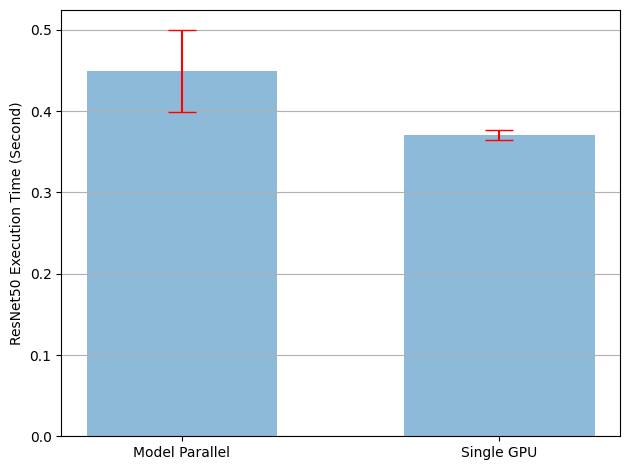

In [90]:
plot([mp_mean, rn_mean],
     [mp_std, rn_std],
     ['Model Parallel', 'Single GPU'],
     'mp_vs_rn.png')

In [91]:
mp_mean, rn_mean

(0.4490540227969177, 0.37082438777433707)